# Finding exoplanets with Python + Lightkurve

In [1]:
!pip install lightkurve

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 2.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\perez\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np
print(lk.__version__)

2.5.1


C:\Users\perez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# Let's look at a star we know has a planet
*If we can spot a blob periodically transiting between the star and us, chances are it's an exoplanet*


<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

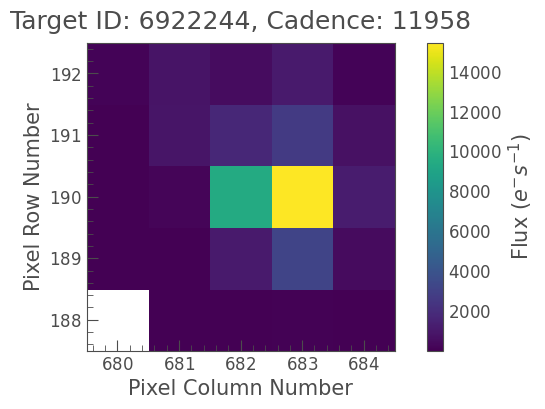

In [5]:
# Download the pixelfile for a given star
# A quarter means a quarter of a year
pixelFile = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
#pixelFile = search_targetpixelfile('TIC 152738837', author="TESS", cadence="long", sector=4).download()
# Show a single snapshot
pixelFile.plot(frame=42)

1) Que es la función de dispersión del punto (Point Spread Function, PSF) de una estrella?

In [7]:
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

# We may find it easier to spot the pattern if we flatten the curve
flat_lc = lc.flatten()
flat_lc.plot()

period = np.linspace(1, 5, 20)
# BLS = Box Least Squares
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

In [8]:
# We'll combine the individual frames into a lightcurve
# Aperture masks make the image look better for analysis
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

# We may find it easier to spot the pattern if we flatten the curve
flat_lc = lc.flatten()
flat_lc.plot()

# Phase-fold the light curve to verify that the period and transit time
# correspond to the transit signal
# This puts the frequency spikes on top of each other if we get the period right
folded_lc = flat_lc.fold(period=3.5263)
folded_lc.plot()

# How to discover the correct period?
# Use a periodogram to show all the repetitive patterns in your graph
# Gives you the most likely candidate

# Periodograms are an estimate of the spectral density of a signal
# (An estimation of what the Fourier Transform of the data would look like
#  if it were a continuous function https://arxiv.org/pdf/1703.09824.pdf)

period = np.linspace(1, 5, 20)
# BLS = Box Least Squares
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

# Period value corresponding to the highest peak in the periodogram
planet_x_period = bls.period_at_max_power

planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Folding can yield a lot of information about the planet
# The depth can tell you about the size, etc
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-2,2)

print(planet_x_period)
print(planet_x_t0)
print(planet_x_dur)


3.5263157894736845 d
353.56132485035283
0.15 d


# Let's try and find a planet!
*Pick a star and try to see if there's something transiting in front of it*

## Selecting a star

In [ ]:
# Use TESS data. That's being updated regularly. Kepler is already well analysed

# Downloading MAST data
# https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

# Look for nearby stars
# MAST catalogs -> TESS CTL v8.01 -> Advanced Search
# Has 9.5 million records

# Narrow down the search as you like

# For example:
# T_eff = Temperature between 2000 and 3500
#         These are red dwarfs and tend to have rapidly orbiting planets
#         Which fits the 24 day time sampling rate of TESS

# Distance = Between 12 and 24 parsecs
#            Because we are not able to do the Kessel run in less than 12

# Magnitud: V < 14 (opcional, más brillantes = mejor calidad de datos).

# Take the ID, e.g. 140206488

# Double-check in EXOMAST to see if a planet has already been found
# https://exo.mast.stsci.edu/

# Put the name in MAST search and find TESS data
# We can try to access this with search_targetpixelfile
# OR download the data to a local folder

# Analyze the star

In [ ]:
# Let's download the pixelfile for a given star
# And save it to a local folder (See download helper below)

# Command to search for file - often is not available, so that's why we download more manually
# pixelFile = search_targetpixelfile('KIC 6922244', author="TESS", cadence="long", quarter=4).download()

tpf = TessTargetPixelFile("/TESS/MAST_2025-09-07T2327/TESS/tess2021310001228-s0045-0000000046125330-0216-s/tess2021310001228-s0045-0000000046125330-0216-s_tp.fits")
# Show a single snapshot
tpf.plot(frame=42)

# Plot the lightcurve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

# Flatten it
flat_lc = lc.flatten()
flat_lc.plot()

# Try and find the period of the most prominent orbiting object
period = np.linspace(0.5, 10, 1000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Phase-fold the ligthcurve based on the discovered period at max power
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-3,3)

print(planet_x_period)
print(planet_x_t0)
print(planet_x_dur)

## Download helper
You can add the URL of the TESS data zip file to be downloaded here and
get the archive unzipped into the local folder

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

product_group_id = '71233337'
url = 'https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=' + product_group_id
destination = '/TESS/'
#destination = '/KEPLER/'

download_and_unzip(url, destination)


# Estrellas para la detección de exoplanetas



1) Utilizando los archivos fits, indique cual de las  siguientes estrellas poseen exoplanetas, justifique sus respuestas.

*   TIC 172900988
*   TIC 393818343
*   TIC 290131778
*   TIC 22567172
*   TIC 439967669
*   TIC 237913194

2) Utilizando los datos en linea y con ayuda del paquete lightkurve, determine cual las siguientes estrellas poseen exoplanetas, justifique sus respuestas.

* KIC 11446443
* KIC 10874614
* KIC 11804465
* KIC 10925104
* KIC 10264660
* KIC 5090690


3) Utilice el catalogo MAST y escoga 10 estrellas que esten bajo el criterio:

* T_eff = Temperature between 2000 and 3500
* Distance = Between 12 and 24 parsecs
* Magnitud: V < 14 (más brillantes = mejor calidad de datos).

E identifique y explique si a estas estrellas se les puede adjudicar o no un exoplaneta.

4) No olvide responder las preguntas que se planteen en clase.
